# Projekt IUM – 2023L

##### Temat 8. - “Nasza baza utworów jest całkiem bogata – opisywane są one wieloma ciekawymi parametrami. Dlaczego jednak do tej pory nikt nie oznaczył czy są w skali dur czy mol? Musimy zmienić tę sytuację!”

### Autorzy:
 - Gabriela Topczewska
 - Karol Rogoziński

## Etap 1. - Analiza danych i wymagań

### Problem biznesowy

W bazie naszego Klienta brakuje oznaczeń skali utworów (czy są molowe czy durowe). Naszym zadaniem będzie próba jej wyznaczenia na podstawie baz danych z informacjami o utworach dostarczonych przez Klienta.

Zadanie modelowania wraz z założeniami oraz definicję sukcesu wyznaczymy po analizie dostarczonych danych.


### Wstępna analiza

Po otrzymaniu pierwszego pakietu z danymi, przeprowadziliśmy ich analizę.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split


In [2]:
artists_df = pd.read_json('./data/artists.jsonl', lines=True)
sessions_df = pd.read_json('./data/sessions.jsonl', lines=True)
track_storage_df = pd.read_json('./data/track_storage.jsonl', lines=True)
tracks_df = pd.read_json('./data/tracks.jsonl', lines=True)
users_df = pd.read_json('./data/users.jsonl', lines=True)


In [3]:
artists_df.head()


,id,name,genres
0,-1,Raghu Dixit,None
1,7b6Ui7JVaBDEfZB9k6nHL0,The Local Train,None
2,4bvGDTEPFnllKiJaEZGuXk,Achint,[indian folk]
3,0n4a5imdLBN24fIrBWoqrv,Because,"[opm, pinoy hip hop, pinoy r&b, pinoy trap, ta..."
4,4gdMJYnopf2nEUcanAwstx,Anuv Jain,"[hindi indie, indian indie, indian singer-song..."


In [4]:
sessions_df.head()


,timestamp,user_id,track_id,event_type,session_id
0,2022-05-18 23:02:03.000,NaN,13BZ3E10qOkANCQs5EMhOl,PLAY,124
1,2022-05-18 23:05:14.867,101.0,,ADVERTISEMENT,124
2,2022-05-18 23:05:35.867,NaN,,BUY_PREMIUM,124
3,2022-05-18 23:06:01.867,101.0,4nlwMawmahyuJrEQ9Oargh,PLAY,124
4,2022-05-19 21:54:57.000,101.0,5vgerDk8eY7uGHJdDhiszD,PLAY,125


In [5]:
track_storage_df.head()


,track_id,storage_class,daily_cost
0,708ZiYL3ydBWHS2a7gvJB3,SLOW,0.003752
1,48SFtLr5URCI97X2Ynfdnc,SLOW,0.014561
2,1y0U0HAe5QfTRzOsz74bOt,SLOW,0.008304
3,2TlbZ8JhF9ORa7lJylxABw,SLOW,0.012207
4,7ij5kN8jwXr8fZD54M0xb6,SLOW,0.011799


In [6]:
tracks_df.head()


,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,708ZiYL3ydBWHS2a7gvJB3,031 - Der Schatz im Silbersee I - Teil 39,13.0,75040,0,0PCtW4w0RN89andUBQ3TVv,1968-09-11,0.740,0.891,7,-7.480,0.8920,0.839,0.000000,0.869,0.557,51.496
1,None,Par Avion (Live) ( 2014 - Remaster) - Live; 20...,0.0,291227,0,2yTUYhIf8fxptTIy3KLuJD,2014,0.603,0.517,6,-8.504,0.0235,0.695,0.000003,0.744,0.327,96.181
2,1y0U0HAe5QfTRzOsz74bOt,None,25.0,166080,0,338mC0yGyX0C9of8QMJ5hK,1950-01-01,0.313,0.116,0,-12.645,0.0319,0.953,0.331000,0.161,0.255,74.071
3,2TlbZ8JhF9ORa7lJylxABw,Kathysterisi,14.0,244133,0,5A4ExW2nMBFRy2JDoYUcUE,1998,0.958,0.635,11,-7.853,0.2590,0.167,0.000000,0.362,0.866,108.024
4,None,Aleni Aleni,51.0,235974,0,48CUA59SDed3IdCctKndud,2015,0.684,0.839,4,-6.457,0.0658,0.120,0.000000,0.354,0.580,128.051


In [7]:
users_df.head()


,user_id,name,city,street,favourite_genres,premium_user,id
0,101,Rozalia Cyman,Warszawa,ul. Działkowa 26,"[vocal jazz, pop rock, alternative rock]",NaN,NaN
1,102,Anita Sabała,Poznań,plac Szarych Szeregów 61,None,1.0,NaN
2,103,Artur Kucewicz,Gdynia,ulica Borowa 33,"[tropical, pop rock, tropical]",1.0,NaN
3,104,Robert Nóżka,Szczecin,pl. Wilcza 09,"[metal, new wave, new romantic]",1.0,-1.0
4,105,Eryk Kołak,Warszawa,ulica Wypoczynkowa 347,"[folk, argentine rock, funk]",1.0,-1.0


Z powyższych tabel najbardziej użyteczna ze względu na nasz cel wydaje się tablica tracks.jsonl.

Z tego powodu to na niej skupimy się w dalszej części analizy.


W celu lepszego zrozumienia danych znaleźliśmy opisy atrybutów na stronie renomowanego serwisu.

Oto kluczowe z nich:

---

```
danceability
```
Danceability opisuje, jak bardzo utwór nadaje się do tańca na podstawie kombinacji elementów muzycznych, w tym tempa, stabilności rytmu, siły beatu i ogólnej regularności. Wartość 0,0 oznacza, że utwór jest najmniej odpowiedni do tańca, a wartość 1,0 oznacza, że jest on najbardziej odpowiedni do tańca.

---

```
key
```
Klucz, w którym znajduje się utwór. Liczby całkowite są mapowane na dźwięki przy użyciu [standardowej notacji klas dźwięków](https://en.wikipedia.org/wiki/Pitch_class). Na przykład 0 = C, 1 = C♯/D♭, 2 = D, itd. Jeśli nie wykryto klucza, wartość wynosi -1.

---

```
valence
```
Miara od 0,0 do 1,0 opisująca pozytywność muzyczną przekazywaną przez utwór. Utwory z wysokim valence brzmią bardziej pozytywnie (np. szczęśliwe, radosne, euforyczne), podczas gdy utwory z niskim valence brzmią bardziej negatywnie (np. smutne, przygnębione, złościące).

---

```
speechiness
```
Parametr "speechiness" wykrywa obecność wokalu mówionego w utworze muzycznym. Im nagranie jest bardziej zbliżone do mowy (np. program radiowy, audiobook, poezja), tym wartość atrybutu jest bliższa 1,0. Wartości powyżej 0,66 opisują utwory, które prawdopodobnie składają się wyłącznie z mowy. Wartości między 0,33 a 0,66 opisują utwory, które mogą zawierać zarówno muzykę, jak i mowę, zarówno w sekcjach, jak i nakładające się na siebie, w tym również rap. Wartości poniżej 0,33 najprawdopodobniej reprezentują muzykę lub inne utwory niewyraźnie mówione.

---


Dokładniejsze opisy wraz z pozostałymi parametrami znajdują się poniższym linkiem:

[Dokumentacja Spotify API](https://developer.spotify.com/documentation/web-api/reference/get-audio-features?fbclid=IwAR2kwVxQCsYiUM7ubHt5aHdupFa5Ap1B6OiL5cSdk5fcgehaWQL4XkF7zY0)

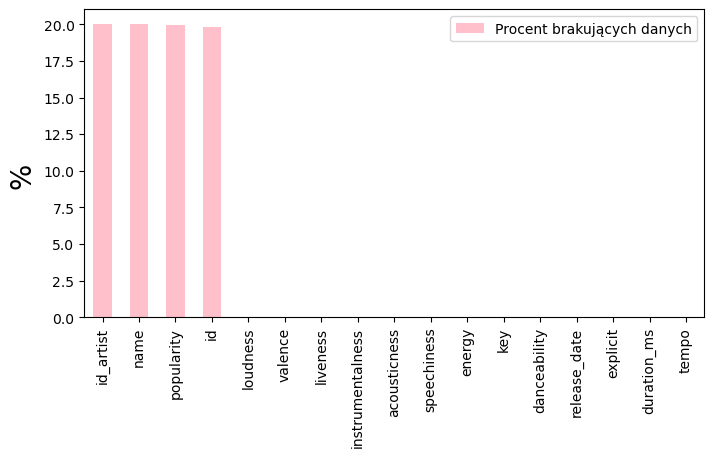

In [8]:
# Analiza brakujących wartości

pd.DataFrame(tracks_df.isna().sum() / tracks_df.shape[0] * 100).sort_values(
        by=[0], ascending=False
    ).plot(kind='bar', figsize=(8, 4), color='pink')

plt.legend(['Procent brakujących danych'])
plt.ylabel('%   ', fontsize=20)
plt.show()

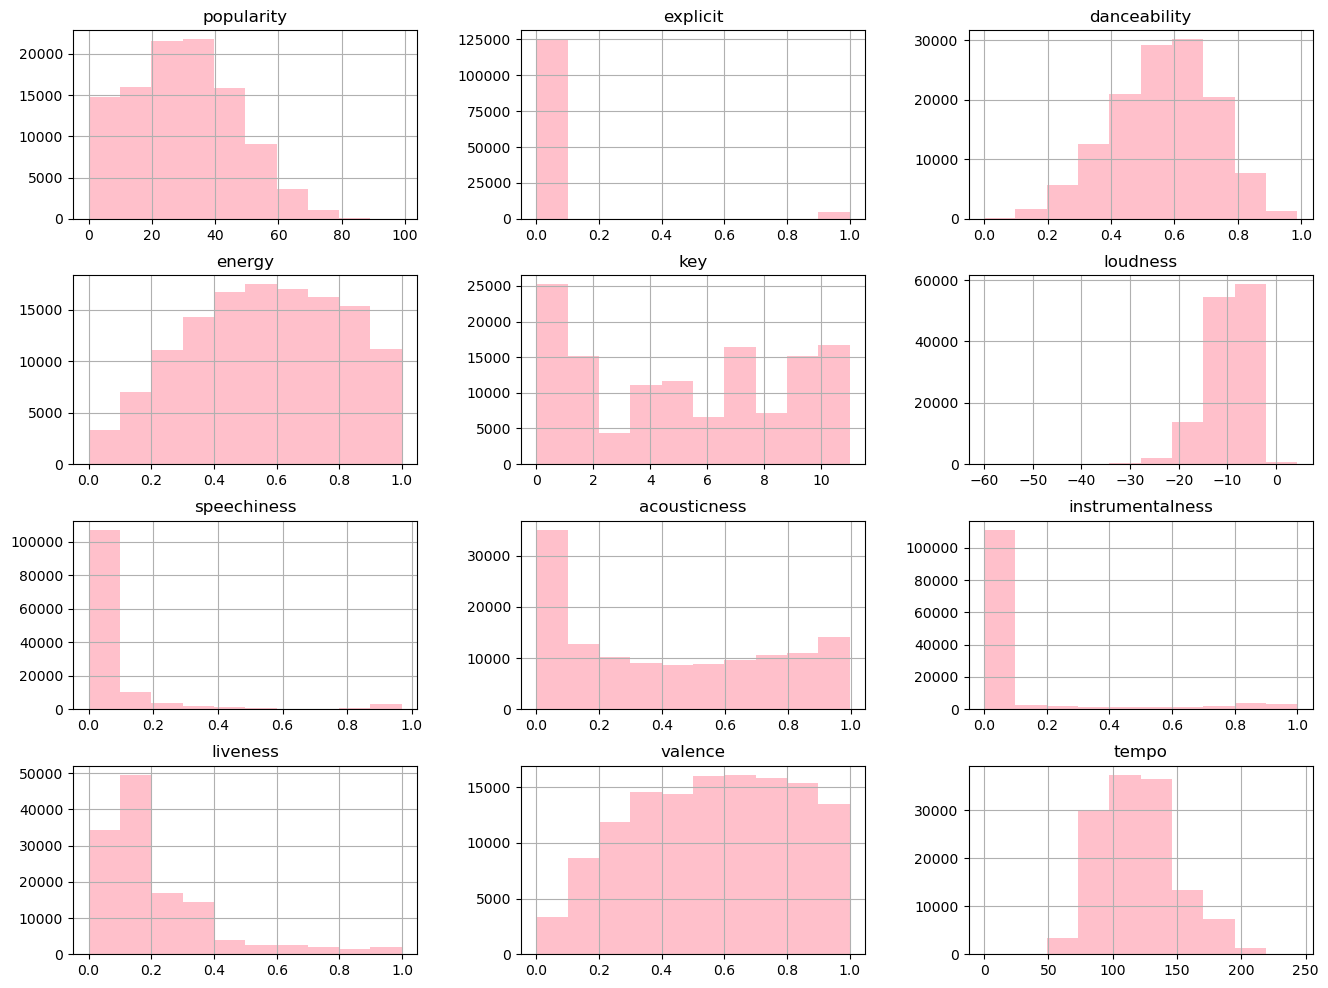

In [9]:
# Analiza rozkładów w celu poszukiwania wartości brakuących - z dokumentacji wynika, że charakteryzują się czasami wartością -1

tracks_df.drop(columns='duration_ms').hist(color='pink', figsize=(16, 12))
plt.show()

Możemy zauważyć, że chociaż większość kolumn nie posiada braków, to cztery z nich mają po ~20% wartości brakujących.

Przy okazji widzimy, że kolumny dzielą się na takie, gdzie rozkład jest prawie normalny i takie, gdzie wartości skupiają się wokół jakiejś konkretnej.

### Wnioski ze wstępnej analizy

Dostarczone dane mają potencjał, jednak nie są idealne. Oto główne problemy jakie napotkaliśmy:
 - Brak jakichkolwiek informacji o skali utworów - uczenie maszynowe opiera się na treningu na istaniejących przykładach, więc bez jakichkolwiek danych treningowych na ten temat, stworzenie modelu będzie praktycznie niemożliwe.
 - Braki w danych. W kilku kolumnach kluczowej dla nas tabeli występują wartości brakujące. Należałoby je uzupełnić.

Poprosiliśmy Klienta o rozwiązanie powyższych problemów, przy okazji prosząc go by w miarę możliwości rozszerzył dane o kolejne atrybuty utworów, jeśli będzie to możliwe (np. metrum) oraz dodanie kolejnych wierszy. Poprosiliśmy także, aby w bazie z artystami znaleźli się wykonawcy dzieł, które zostaną dodane.

### Analiza uzupełnionych danych

In [10]:
artists_df = pd.read_json('./data_v2/artists.jsonl', lines=True)
tracks_df = pd.read_json('./data_v2/tracks.jsonl', lines=True)


In [11]:
tracks_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259297 entries, 0 to 259296
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                259297 non-null  object 
 1   name              259297 non-null  object 
 2   popularity        259297 non-null  int64  
 3   duration_ms       259297 non-null  int64  
 4   explicit          259297 non-null  int64  
 5   id_artist         259297 non-null  object 
 6   release_date      259297 non-null  object 
 7   danceability      259297 non-null  float64
 8   energy            259297 non-null  float64
 9   key               259297 non-null  int64  
 10  mode              51859 non-null   float64
 11  loudness          259297 non-null  float64
 12  speechiness       259297 non-null  float64
 13  acousticness      259297 non-null  float64
 14  instrumentalness  259297 non-null  float64
 15  liveness          259297 non-null  float64
 16  valence           25

Możemy zauważyć, że zgodnie z naszą prośbą Klient uzupełnił brakujące dane oraz dodał nowe atrybuty i 100k wierszy. Niestety, kluczowa dla nas kolumna, czyli mode jest uzupełniona jedynie w 20% przypadków. Kontaktowaliśmy się w tej sprawie z Klientem, jednak okazało się, że nie może rozwiązać tego problemu.

W związku z tym, dalszą analizę przeprowadzimy jedynie na olabelowanych danych, ponieważ pozostałe z nich prawdopodobnie nie zostaną wykorzystane przy tworzeniu modelu.


In [12]:
tracks_df = tracks_df[~tracks_df['mode'].isna()]
tracks_df.shape


(51859, 19)

In [13]:
# Sprawdzenie istanienia duplikatów

tracks_df[['id', 'name']].duplicated().sum()


0

Analizowany przez nas zbiór utworów najprawdopodbiej jest unikalny.

In [14]:
tracks_df['mode'] = tracks_df['mode'].apply(lambda x: 'Dur' if x == 1 else 'Moll')

In [15]:
# Rozkład klas

tracks_df['mode'].value_counts() / tracks_df.shape[0] * 100


Dur     66.343354
Moll    33.656646
Name: mode, dtype: float64

Nasz zbiór jest niestety niezbalansowany - istnieje 2 razy więcej utworów w skali dur niż moll.

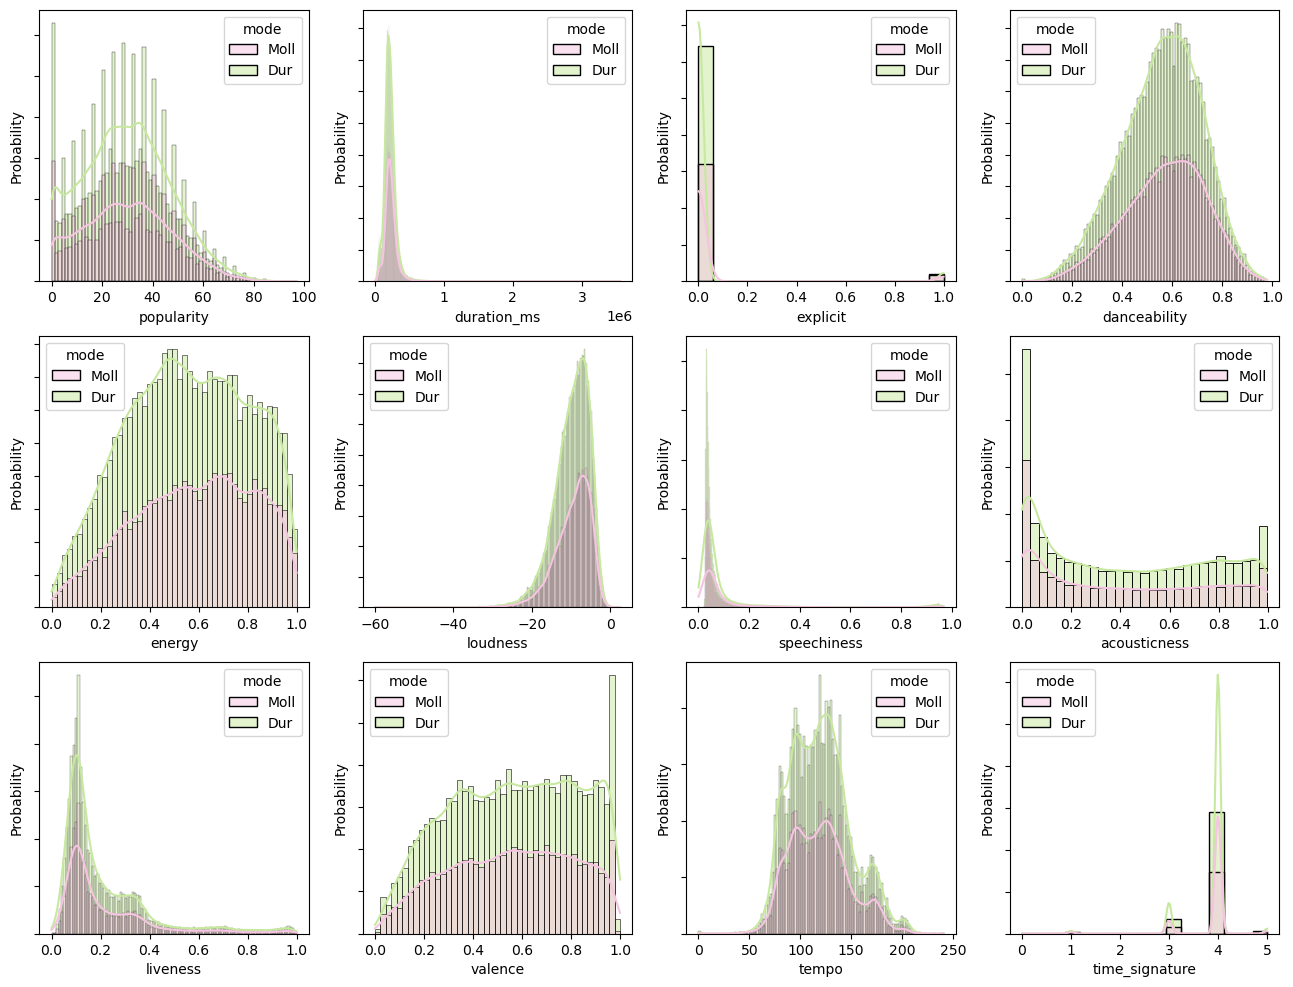

In [16]:
# Analiza rozkładów dla poszczególnych klas
fig, ax =plt.subplots(3, 4, figsize = (16, 12))

for i, col in enumerate(
        tracks_df.drop(
            columns=['id', 'name', 'id_artist', 'mode', 'release_date', 'instrumentalness', 'key']
            ).columns
        ):

    sns.histplot(
        x=tracks_df[col],
        hue=tracks_df['mode'],
        palette='PiYG',
        kde=True,
        stat='probability',
        ax = ax[i // 4, i % 4]
    ).set(yticklabels=[])

plt.show()


Rozkład wartości danych numerycznych jest bardzo zbliżony dla obydwu klas. Może to utrudnić nasze zadanie modelowania.

Kolumnę *key* potraktujemy osobno, ponieważ pomimo tego, że jest numeryczna, dokumentacja mówi nam, że jej wartości powinnyśmy traktować kategorycznie.

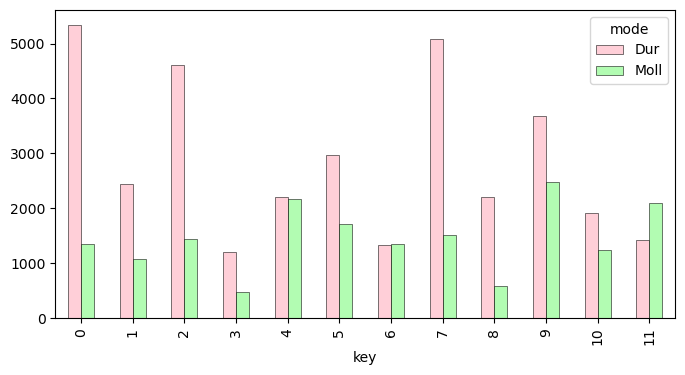

In [17]:
pd.DataFrame(
    tracks_df.groupby(by=['key'])['mode'].value_counts()
    ).rename(columns={'mode': 'count'}
        ).reset_index().pivot(
            index='key', columns='mode', values='count'
        ).plot(
            kind='bar',
            color=('pink', 'palegreen'),
            edgecolor='black',
            linewidth=.5,
            alpha=.75,
            figsize=(8, 4)
            )

plt.show()

Jeśli chodzi o klucz jest już trochę lepiej. Wyraźnie widać, że niektóre z nich są bardziej charakterystyczne dla skali moll (4, 6, 11), ponieważ pomimo mniejszej liczebności tej klasy potrafią dorównywać, a nawet przewyższać liczbę występień dla klasy dominującej.

Wynika z tego, że *key* może być użytecznym atrybutem przy klasyfikacji.


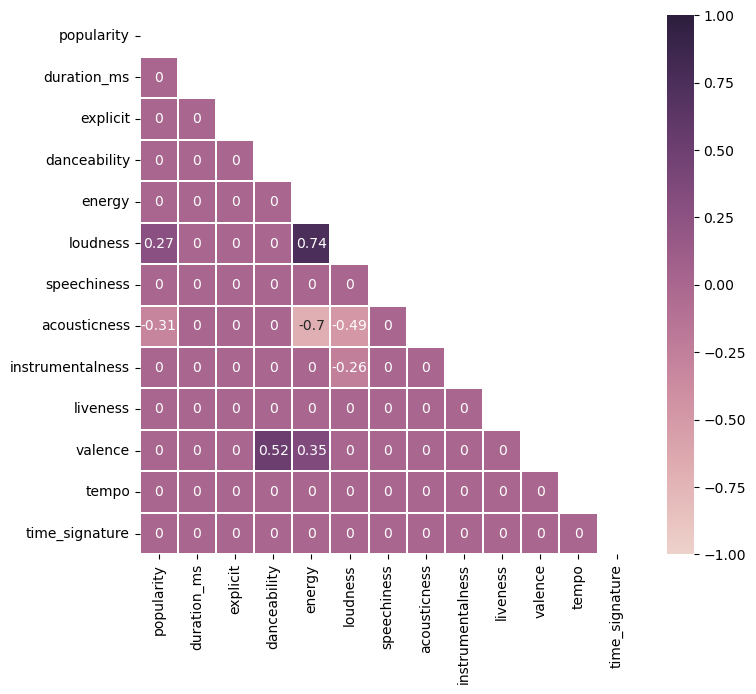

In [18]:
# Sprawdzenie korelacji. Dla zwiększenia czytelności potraktujemy wszystkie wartości absolutne poniżej 0.25 jako 0.

plt.figure(figsize=(8, 7))

corr = tracks_df.drop(columns=['key']).corr().mask(abs(tracks_df.corr()) < 0.25, 0)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    linewidths=.01,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True,
    mask=mask,
    vmin=-1,
    vmax=1
)

plt.show()


Większość aktualnie używanych atrybutów nie ma ze sobą zbyt wielu powiązań. Możemy jednak zauważyć, że:
 -  *Energy* koreluje z wieloma parametrami, jak: *loudness*, *acousticness*, *valence*.
 -  *Valence* dodatkowo łączy się z *danceability*.
 -  *Acousticness* ma wpływ na *loudness*  i *popularity*.

Powyższe wnioski są zgodne z logiką i wiedzą ekspercką. Postaramy się wykorzystać je w dalszych etapach modelowania.


In [19]:
tracks_df['mode'] = tracks_df['mode'].apply(lambda x: 1 if x == 'Dur' else 0)


<AxesSubplot:>

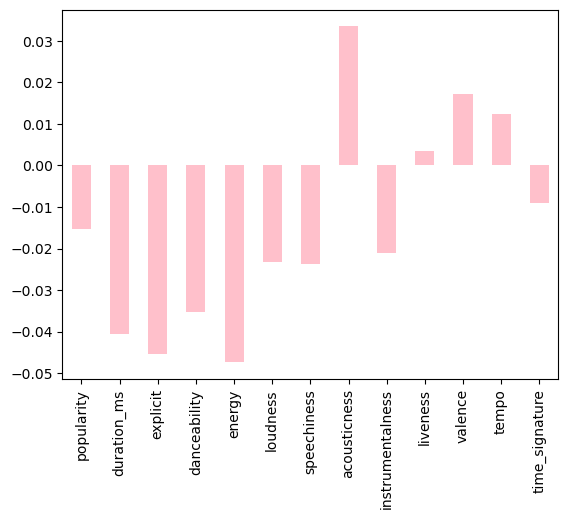

In [20]:
# Korelacja z wartością przewidywaną

tracks_df.drop(columns=['mode', 'key']).corrwith(tracks_df['mode']).plot(kind='bar', color='pink')


Niestety, wszystkie wartości ciągłe są skorelowane ze skalą utworu w bardzo znikomy sposób.


### Zadanie modelowania

Po powyższej analizie i konsultacji z Klientem, doszliśmy do wniosku, że zadaniem modelowania powinna być klasyfikacja z wykorzystaniem uczenia nadzorowanego.

Przeprowadzimy krótki eksperyment, w celu wyznaczenia punktu odniesienia i kryterium sukcesu.


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df.drop(columns=['mode', 'id', 'name', 'id_artist', 'release_date']),
    tracks_df['mode'],
    test_size=0.2,
    random_state=42
)


In [22]:
xgbc = XGBClassifier()

xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, preds))
print('Recall:', recall_score(y_test, preds))
print('Precision:',precision_score(y_test, preds))
print('F1:',f1_score(y_test, preds))
print()
print('Predicted class balance:')
print(pd.Series(preds).value_counts()/len(preds)*100)
print()
print('Original:')
print(y_test.value_counts()/y_test.shape[0]*100)


Accuracy: 0.6850173544157346
Recall: 0.8798602009611184
Precision: 0.7121640735502122
F1: 0.7871799882743796

Predicted class balance:
1    81.797146
0    18.202854
dtype: float64

Original:
1    66.207096
0    33.792904
Name: mode, dtype: float64


Wrzucenie *suchych* danych do modelu skutkuje skutecznością na poziomie 68%. Niestety w wynikach wyraźnie widać wcześniejszy problem wynikający z dysproporcji klas - ponad 80% przypadków jest klasyfikowanych jako Dur. 


### Kryterium sukcesu

Razem z Klientem ustaliliśmy, że zadowalająca będzie skuteczność na poziomie ~70%. Oczywiście liczymy na więcej, jednak dotychczasowa analiza danych nie wskazuje na potencjalnie wysoki wzrost, więc postanowiliśmy pozostawić sobie margines błędu.

W celu zwiększenia skuteczności podejmiemy następujące kroki:
 1. Skalowanie danych - nasze dane mają rozkłady w różnych przedziałach. Po znormalizowaniu model powinien radzić sobie z nimi nieco lepiej.
 2. Kategoryzacja kolumny *key* - obecnie potraktowaliśmy go jako wartość numeryczną, jednak z dokumentacji wynika, że jest kategoryczna.
 3. Usunięcie atrybutów - przeprowadzimy analizę wpływu poszczególnych czynników na wynik modelu i pozbędziemy się wartości powodujących szum.
 4. Dodanie nowych atrybutów - spróbujemy uwzględnić więcej cznników podczas modelowania (np. może gatunek utworu lub czas jego powstania jest jakoś powiązany ze skalą?)
 5. Wyrównanie dysproporcji klas - jeśli pozostałe kroki nie wpłyną na balans przewidywanych klas, spróbujemy naprawić go za pomocą hiperparametrów lub sztucznym tworzeniem próbek (SMOTE)
 6. Wypróbowanie różnych modeli i dobranie hiperparametrów - na koniec, poprzez walidację krzyżową, postaramy się dojść do jak najlepszych wyników.
